In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


sys.path.insert(0,"../src/")
import SGD
import CostFunctions

sys.path.insert(0,"../../project_1/src/")
from FrankeFunction import *
from utils import plot_settings
import stat_tools
import linear_regression

FIGSIZE = (4, 3)
FIGPATH = "../figs/"
plot_settings()

In [2]:
N = 500                # Number of data points
noise_scale = 0.2      # Size of artificial noise
MB_num = int(N / 32)      # Num of minibatches
n_epochs = 100        # Number of epochs in SGD


# Generate data
x = np.random.uniform(0, 1, N)
y = np.random.uniform(0, 1, N)
z = FrankeFunction(x, y)

# Add standard normal noise:
z = z + noise_scale * np.random.normal(0, 1, len(z))
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2)

# Center the response 
z_train_intercept = np.mean(z_train)
z_train = z_train - z_train_intercept
z_test = z_test - z_train_intercept

# Parameters to test
degrees = np.arange(2, 14)
lambdas = np.logspace(-10, 0, 5)

# Store Stochastic Gradient Descent MSE
OLS_MSE_SGD = np.zeros(len(degrees))
Ridge_MSE_SGD = np.zeros([len(degrees), len(lambdas)])

# Store Analytic Solution MSE
OLS_MSE_Analytic = np.zeros(len(degrees))
Ridge_MSE_Analytic = np.zeros([len(degrees), len(lambdas)])

In [3]:
degree = 6

X_train = linear_regression.design_matrix_2D(x_train, y_train, degree)
X_test = linear_regression.design_matrix_2D(x_test, y_test, degree)

# Scale design matrix according to the training data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Remove the intercept
X_train_scaled = X_train_scaled[:,1:]
X_test_scaled = X_test_scaled[:,1:]

N_predictors = int((degree + 1) * (degree + 2) / 2) - 1 # Don't include intercept
w_init = np.random.randn(N_predictors) # Random initial weights

In [4]:
X_train_scaled.shape
N_predictors

27

Explore the effects of different batch sizes, learning rate and momentum

In [5]:
learning_rate = np.logspace(-5, -2, 4)
tot_epochs = 2000
epochs_per_itter = 1
num_itter = int(tot_epochs / epochs_per_itter)

MB_num = [int(N / 32), int(N / 128)]
mse_learning_rate = np.zeros([len(MB_num), len(learning_rate), num_itter])

np.random.seed(2020)

# Initialize the SGD using the same weights across all attempts
init_w = np.random.randn(N_predictors)

for k in range(len(MB_num)):
    for i in range(len(learning_rate)):    
        w_OLS_SGD = SGD.SGD(
            x = X_train_scaled, 
            y = z_train, 
            M = MB_num[k],
            init_w = init_w, 
            n_epochs = epochs_per_itter, 
            learning_rate = learning_rate[i], 
            cost_gradient = CostFunctions.OLS_cost_gradient)
        mse_learning_rate[k, i, 0] = stat_tools.MSE(z_test, X_test_scaled @ w_OLS_SGD)

        for j in range(1, num_itter):
            w_OLS_SGD = SGD.SGD(
                x = X_train_scaled, 
                y = z_train, 
                M = MB_num[k],
                init_w = w_OLS_SGD, 
                n_epochs = epochs_per_itter, 
                learning_rate = learning_rate[i], 
                cost_gradient = CostFunctions.OLS_cost_gradient)

            mse_learning_rate[k, i, j] = stat_tools.MSE(z_test, X_test_scaled @ w_OLS_SGD)

In [6]:
learning_rate = np.logspace(-5, -2, 4)
tot_epochs = 2000
epochs_per_itter = 1
num_itter = int(tot_epochs / epochs_per_itter)
momentum = 0.75

MB_num = [int(N / 32), int(N / 128)]
mse_learning_rate_momentum = np.zeros([len(MB_num), len(learning_rate), num_itter])

np.random.seed(2020)

# Initialize the SGD using the same weights across all attempts
init_w = np.random.randn(N_predictors)
for k in range(len(MB_num)):
    for i in range(len(learning_rate)):    
        w_OLS_SGD = SGD.SGDM(
            x = X_train_scaled, 
            y = z_train, 
            M = MB_num[k],
            init_w = init_w, 
            n_epochs = epochs_per_itter, 
            learning_rate = learning_rate[i], 
            momentum = momentum,
            cost_gradient = CostFunctions.OLS_cost_gradient)
        mse_learning_rate_momentum[k, i, 0] = stat_tools.MSE(z_test, X_test_scaled @ w_OLS_SGD)

        for j in range(1, num_itter):
            w_OLS_SGD = SGD.SGDM(
                x = X_train_scaled, 
                y = z_train, 
                M = MB_num[k],
                init_w = w_OLS_SGD, 
                n_epochs = epochs_per_itter, 
                learning_rate = learning_rate[i], 
                momentum = momentum,
                cost_gradient = CostFunctions.OLS_cost_gradient)

            mse_learning_rate_momentum[k, i, j] = stat_tools.MSE(z_test, X_test_scaled @ w_OLS_SGD)

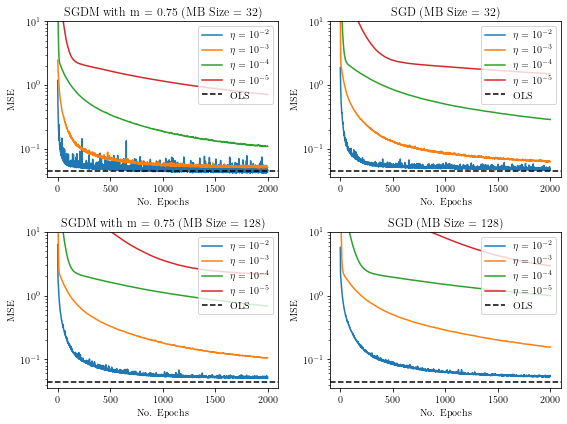

In [7]:
w_OLS_Analytic = linear_regression.OLS_SVD_2D(X_train_scaled, z_train)
mse_OLS_analytic = stat_tools.MSE(z_test, X_test_scaled @ w_OLS_Analytic)

YLIMS = [mse_OLS_analytic*0.8, 10]

plt.figure(figsize=FIGSIZE * np.array([2, 2]))
plt.subplot(221)
for i in range(len(learning_rate)-1, -1, -1):
    plt.semilogy(mse_learning_rate_momentum[0, i, :], label="$\eta = 10^{%i}$" % int(np.log10(learning_rate[i])))
plt.xlabel("No. Epochs")
plt.ylabel("MSE")
plt.ylim(YLIMS)
plt.axhline([mse_OLS_analytic], color="black", ls="--", label="OLS")
plt.legend(loc="upper right")
plt.title(f"SGDM with m = {momentum} (MB Size = {32})")

plt.subplot(222)
for i in range(len(learning_rate)-1, -1, -1):
    plt.semilogy(mse_learning_rate[0, i, :], label="$\eta = 10^{%i}$" % int(np.log10(learning_rate[i])))
plt.xlabel("No. Epochs")
plt.ylabel("MSE")
plt.axhline([mse_OLS_analytic], color="black", ls="--", label="OLS")
plt.ylim(YLIMS)
plt.legend(loc="upper right")
plt.title(f"SGD (MB Size = {32})")


plt.subplot(223)
for i in range(len(learning_rate)-1, -1, -1):
    plt.semilogy(mse_learning_rate_momentum[1, i, :], label="$\eta = 10^{%i}$" % int(np.log10(learning_rate[i])))
plt.xlabel("No. Epochs")
plt.ylabel("MSE")
plt.ylim(YLIMS)
plt.axhline([mse_OLS_analytic], color="black", ls="--", label="OLS")
plt.legend(loc="upper right")
plt.title(f"SGDM with m = {momentum} (MB Size = {128})")

plt.subplot(224)
for i in range(len(learning_rate)-1, -1, -1):
    plt.semilogy(mse_learning_rate[1, i, :], label="$\eta = 10^{%i}$" % int(np.log10(learning_rate[i])))
plt.xlabel("No. Epochs")
plt.ylabel("MSE")
plt.axhline([mse_OLS_analytic], color="black", ls="--", label="OLS")
plt.ylim(YLIMS)
fig_leg = plt.legend(loc="upper right")
plt.title(f"SGD (MB Size = {128})")


plt.tight_layout()
plt.savefig(FIGPATH+"SGD_learning_rate.pdf")

Explore the effects of penalty parameters $\lambda$ wrt. the two best learning rates $\eta = 10^{-3}, 10^{-2}$ and $m = 0.75$ (Stable & unstable with sufficient convergence rates at 2000 epochs)

In [8]:
tot_epochs = 2000
epochs_per_itter = 1
num_itter = int(tot_epochs / epochs_per_itter)

momentum = 0.75
MB_num = int(N / 32)

learning_rate = np.logspace(-4, -2, 3)
penalties = np.logspace(-5, 0, 6)

mse_learning_rate_penalties = np.zeros([len(penalties), len(learning_rate), num_itter])

np.random.seed(2020)
# Initialize the SGD using the same weights across all attempts
init_w = np.random.randn(N_predictors)

for k in range(len(penalties)):
    for i in range(len(learning_rate)):    
        w_Ridge_SGD = SGD.SGDM(
            X_train_scaled, 
            z_train, 
            MB_num,
            init_w, 
            epochs_per_itter, 
            learning_rate[i], 
            momentum,
            CostFunctions.Ridge_cost_gradient,
            penalties[k])
        mse_learning_rate_penalties[k, i, 0] = stat_tools.MSE(z_test, X_test_scaled @ w_Ridge_SGD)

        for j in range(1, num_itter):
            w_Ridge_SGD = SGD.SGDM(
                X_train_scaled, 
                z_train, 
                MB_num,
                w_Ridge_SGD, 
                epochs_per_itter, 
                learning_rate[i], 
                momentum,
                CostFunctions.Ridge_cost_gradient,
                penalties[k])

            mse_learning_rate_penalties[k, i, j] = stat_tools.MSE(z_test, X_test_scaled @ w_Ridge_SGD)

In [9]:
print(penalties)

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00]


0.04422007069147063


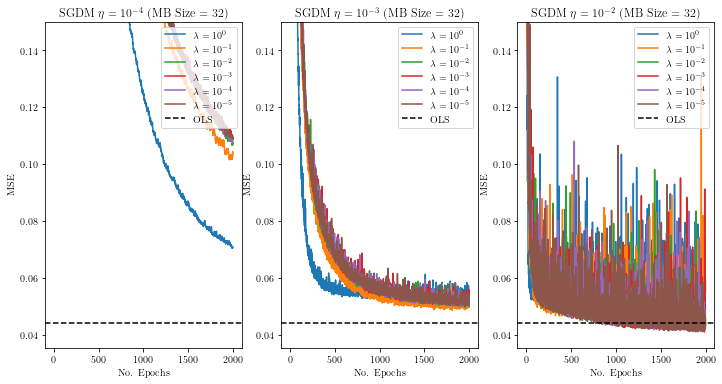

In [10]:
w_OLS_Analytic = linear_regression.OLS_SVD_2D(X_train_scaled, z_train)
mse_OLS_analytic = stat_tools.MSE(z_test, X_test_scaled @ w_OLS_Analytic)

YLIMS = [mse_OLS_analytic*0.8, 1.5e-1]

plt.figure(figsize=FIGSIZE * np.array([3, 2]))
plt.subplot(131)
j = 0
for i in range(len(penalties)-1, -1, -1):
    plt.plot(mse_learning_rate_penalties[i, j, :], label="$\lambda = 10^{%i}$" % int(np.log10(penalties[i])))
plt.xlabel("No. Epochs")
plt.ylabel("MSE")
plt.ylim(YLIMS)
plt.axhline([mse_OLS_analytic], color="black", ls="--", label="OLS")
plt.legend(loc="upper right")
plt.title("SGDM $\eta = 10^{%i}$  (MB Size = 32)" % int(np.log10(learning_rate[j])))

plt.subplot(132)
j = 1
for i in range(len(penalties)-1, -1, -1):
    plt.plot(mse_learning_rate_penalties[i, j, :], label="$\lambda = 10^{%i}$" % int(np.log10(penalties[i])))
plt.xlabel("No. Epochs")
plt.ylabel("MSE")
plt.ylim(YLIMS)
plt.axhline([mse_OLS_analytic], color="black", ls="--", label="OLS")
plt.legend(loc="upper right")
plt.title("SGDM $\eta = 10^{%i}$  (MB Size = 32)" % int(np.log10(learning_rate[j])))

plt.subplot(133)
j = 2
for i in range(len(penalties)-1, -1, -1):
    plt.plot(mse_learning_rate_penalties[i, j, :], label="$\lambda = 10^{%i}$" % int(np.log10(penalties[i])))
plt.xlabel("No. Epochs")
plt.ylabel("MSE")
plt.ylim(YLIMS)
plt.axhline([mse_OLS_analytic], color="black", ls="--", label="OLS")
plt.legend(loc="upper right")
plt.title("SGDM $\eta = 10^{%i}$  (MB Size = 32)" % int(np.log10(learning_rate[j])))

plt.savefig("")

print(mse_OLS_analytic)

No need to repeat analysis from project 1

In [11]:
for i, degree in enumerate(degrees):
    
    # Create design matrices
    X_train = linear_regression.design_matrix_2D(x_train, y_train, degree)
    X_test = linear_regression.design_matrix_2D(x_test, y_test, degree)
    
    # Scale design matrix according to the training data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Remove the intercept
    X_train_scaled = X_train_scaled[:,1:]
    X_test_scaled = X_test_scaled[:,1:]
    
    N_predictors = int((degree + 1) * (degree + 2) / 2) - 1 # Don't include intercept
    w_init = np.random.randn(N_predictors) # Random initial weights
    
    # Solve for optimal weights using OLS Cost function
    w_OLS_Analytic = linear_regression.OLS_SVD_2D(X_train_scaled, z_train)
    
    w_OLS_SGD = SGD.ADAgrad(
        X_train_scaled, 
        z_train, 
        M, 
        w_init, 
        n_epochs, 
        learning_rate, 
        CostFunctions.OLS_cost_gradient)
    
    # Compute the MSE
    OLS_MSE_SGD[i] = stat_tools.MSE(z_test, X_test_scaled @ w_OLS_SGD)
    OLS_MSE_Analytic[i] = stat_tools.MSE(z_test, X_test_scaled @ w_OLS_Analytic)
    
    for j, lambd in enumerate(lambdas):
        # Solve for optimal weights using Ridge Cost function
        w_Ridge_Analytic = linear_regression.Ridge_2D(X_train_scaled, z_train, lambd)
        w_Ridge_SGD = SGD.ADAgrad(
            X_train_scaled, 
            z_train, 
            M, 
            w_init, 
            n_epochs, 
            learning_rate, 
            CostFunctions.Ridge_cost_gradient,
            lambd)
        
        # Compute the MSE
        Ridge_MSE_SGD[i,j] = stat_tools.MSE(z_test, X_test_scaled @ w_Ridge_SGD)
        Ridge_MSE_Analytic[i,j] = stat_tools.MSE(z_test, X_test_scaled @ w_Ridge_Analytic)

NameError: name 'M' is not defined

In [ ]:
plt.semilogy(degrees, OLS_MSE_SGD, label="SGD")
plt.semilogy(degrees, OLS_MSE_Analytic, label="Analytic")
plt.xlabel("Degree")
plt.ylabel("Test MSE")
plt.title("OLS")
plt.legend()

In [ ]:
plt.semilogy(degrees, Ridge_MSE_SGD, color="blue")
plt.semilogy(degrees, Ridge_MSE_Analytic, color="red")
plt.xlabel("Degree")
plt.ylabel("Test MSE")
plt.title("Ridge")